# POLI 175 - Lecture 15

## Regularization I (and a quick detour to talk about KNN)

## Announcement

- Problem Set 02 is on!

- This lecture's participation quiz is on.

- The lecture quiz is on for this, the previous, and the next lectures.

- Problem Set 02 is harder. Please reach out if you need help.

# Detour: K-Nearest Neighbors Classifier

## Class Examples

- Education expenditure dataset

- Pinochet voting dataset

Let us load them all:

In [24]:
## Loading the relevant packages
import pandas as pd
import numpy as np

# Plotting things:
import seaborn as sns
import matplotlib.pyplot as plt

# Loading scikit learn relevant packages (note our new friends!)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, get_scorer_names, mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

In [25]:
## Loading Chile data
chile = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/chilesurvey.csv')
chile_clean = chile.dropna()
chile_clean = chile_clean[chile_clean['vote'].isin(['Y', 'N'])]
chile_clean['vote'] = np.where(chile_clean['vote'] == 'Y', 1, 0)
chile_clean['logincome'] = np.log(chile_clean['income'])
chile_clean['logpop'] = np.log(chile_clean['population'])
dummies = pd.get_dummies(chile_clean['sex'], prefix = 'sex', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['region'], prefix = 'region', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
dummies = pd.get_dummies(chile_clean['education'], prefix = 'education', drop_first = True)
chile_clean = pd.concat([chile_clean, dummies], axis=1)
chile_clean.head()

,region,population,sex,age,education,income,statusquo,vote,logincome,logpop,sex_M,region_M,region_N,region_S,region_SA,education_PS,education_S
0,N,175000,M,65.0,P,35000.0,1.00820,1,10.463103,12.072541,1,0,1,0,0,0,0
1,N,175000,M,29.0,PS,7500.0,-1.29617,0,8.922658,12.072541,1,0,1,0,0,1,0
2,N,175000,F,38.0,P,15000.0,1.23072,1,9.615805,12.072541,0,0,1,0,0,0,0
3,N,175000,F,49.0,P,35000.0,-1.03163,0,10.463103,12.072541,0,0,1,0,0,0,0
4,N,175000,F,23.0,S,35000.0,-1.10496,0,10.463103,12.072541,0,0,1,0,0,0,1


In [26]:
## Education Expenditure Dataset
educ = pd.read_csv('https://raw.githubusercontent.com/umbertomig/POLI175public/main/data/educexp.csv')
educ = educ.set_index('states')
for i in educ.columns:
    educ[i + '_log'] = np.log(educ[i])
educ.head()

,education,income,young,urban,education_log,income_log,young_log,urban_log
states,,,,,,,,
ME,189,2824,350.7,508,5.241747,7.945910,5.859931,6.230481
NH,169,3259,345.9,564,5.129899,8.089176,5.846150,6.335054
VT,230,3072,348.5,322,5.438079,8.030084,5.853638,5.774552
MA,168,3835,335.3,846,5.123964,8.251925,5.815026,6.740519
RI,180,3549,327.1,871,5.192957,8.174421,5.790266,6.769642


## Classification

### K-Nearest Neighbors Classifier

- Little detour back to talk about a good algorithm for classification (also very intuitive).

- Given an integer $K$, and a test observation, it says that:

$$ \mathbb{P}(Y = j| X = x_0) \ = \ \dfrac{1}{K}\sum_{i \in N_0} I(y_i = j) $$

- Meaning: classify the observation based on the class of the closest $K$ obs:
    + The one more frequent is the winner.
    
- Closest: the idea of a metric.

## Classification

### K-Nearest Neighbors Classifier

![img](../img/knn1.png)

## Classification

### K-Nearest Neighbors Classifier

![img](../img/knn2.png)

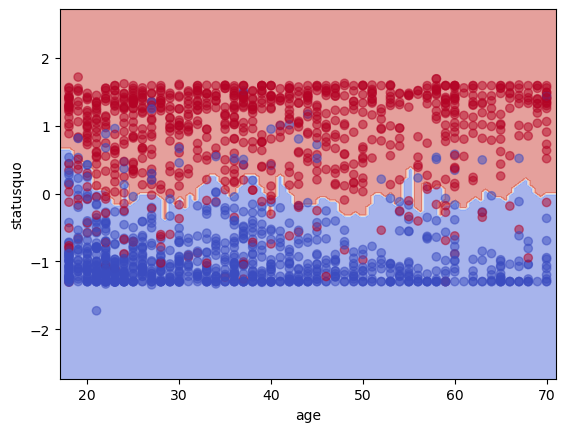

In [4]:
# KNN
X = chile_clean[['age', 'statusquo']]
y = chile_clean['vote']

# Create the model
knn = KNeighborsClassifier(n_neighbors = 10).fit(X, y)

# Plotting the tree boundaries
fig = DecisionBoundaryDisplay.from_estimator(knn, X, response_method="predict",
                                             alpha=0.5, cmap=plt.cm.coolwarm)

# Plotting the data points    
fig.ax_.scatter(x = chile_clean['age'], 
                y = chile_clean['statusquo'], 
                c = y, alpha = 0.5,
                cmap = plt.cm.coolwarm)

plt.show()

In [28]:
## Now choose K!
bigK = list(range(1, 101))
errmea = []
y = chile_clean['vote']
X = chile_clean[['statusquo', 'logincome', 'logpop', 'age']]
for smallk in bigK:
    cv = KFold(n_splits = 10, random_state = 254, shuffle = True)
    knn = KNeighborsClassifier(n_neighbors = smallk)
    scores = cross_val_score(knn, X, y, 
                             scoring = 'accuracy',
                             cv = cv, n_jobs = -1)
    errmea.append(1-scores.mean())
print('Best K is {a}.'.format(a = str(bigK[errmea.index(min(errmea))])))

Best K is 9.


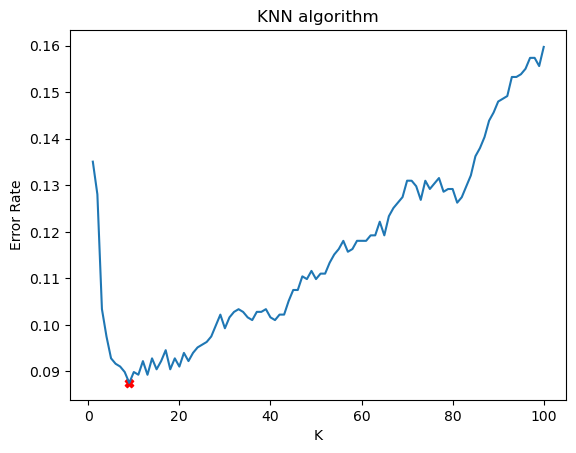

In [29]:
sns.lineplot(x = bigK, y = errmea)
plt.title('KNN algorithm')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.scatter(bigK[errmea.index(min(errmea))], min(errmea), marker='X', color = 'red')
plt.show()

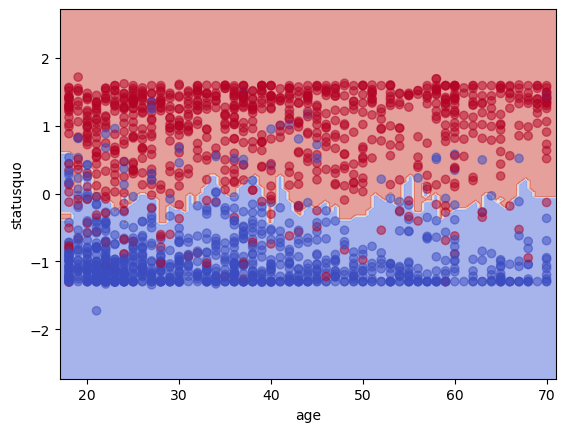

In [30]:
# Plotting the best K (K = 8)
X = chile_clean[['age', 'statusquo']]
y = chile_clean['vote']

# Create the model
knn = KNeighborsClassifier(n_neighbors = 9).fit(X, y)

# Plotting the tree boundaries
fig = DecisionBoundaryDisplay.from_estimator(knn, X, response_method="predict",
                                             alpha=0.5, cmap=plt.cm.coolwarm)

# Plotting the data points    
fig.ax_.scatter(x = chile_clean['age'], y = chile_clean['statusquo'], 
                c = y, alpha = 0.5,
                cmap = plt.cm.coolwarm)

plt.show()

## Stepwise Subset Selection: Code

In [32]:
## Let us predict the education expenditure using
## raws, squares, and cubic powers of the predictors
raws = ['income', 'young', 'urban']
y = educ['education']
X = educ.reset_index()[raws]
for power in range(2, 4):
    for var in raws:
        X[var + '_' + str(power)] = X[[var]] ** power

# Found on stackoverflow
def powerSet(s):
    sets = [[]]
    for i in s:
        newsets = []
        for k in sets:
            newsets.append(k+[i])
        sets += newsets
    return sets

In [9]:
## My best subset selection code
def best_subset_selection(est, X, y, cvn = 5):
    modsAll = powerSet(X.columns)
    mods = {}
    for i in modsAll:
        if i == []:
            mods[0] = {'model': 'Null',
                       'RSS': np.sum((y - np.mean(y)) ** 2)}
        else:
            rss = np.sum((y - est.fit(X[i], y).predict(X[i])) ** 2)
            if len(i) not in mods:
                mods[len(i)] = {'model': i, 'RSS': rss}
            else:
                if mods[len(i)]['RSS'] > rss:
                    mods[len(i)] = {'model': i, 'RSS': rss}
    bestmod = mods.pop(0)
    bestmod.pop('RSS')
    bestmod['Rsquared'] = 0
    for i in mods.values():
        score = cross_val_score(est, X[i['model']], y, cv = cvn, scoring = 'r2').mean()
        if bestmod['Rsquared'] < score:
            bestmod['model'] = i['model']
            bestmod['Rsquared'] = score
    return(bestmod)

print(best_subset_selection(LinearRegression(), X, y))

{'model': ['income', 'urban_2', 'income_3', 'young_3', 'urban_3'], 'Rsquared': 0.46485241542619765}


In [10]:
## My forward subset selection
def forward_subset_selection(est, X, y, cvn = 5):
    variables = list(X.columns)
    mods = {}
    mods[0] = {'model': [], 'RSS': np.sum((y - np.mean(y)) ** 2)}
    for i in range(1, len(variables) + 1):
        mods[i] = {'model': mods[i-1]['model'], 'RSS': mods[i-1]['RSS']}
        for j in [item for item in variables if item not in mods[i-1]['model']]:
            varsaux = mods[i-1]['model'] + [j]
            rss = np.sum((y - est.fit(X[varsaux], y).predict(X[varsaux])) ** 2)
            if mods[i]['RSS'] > rss:
                mods[i]['model'] = varsaux
                mods[i]['RSS'] = rss
    bestmod = mods.pop(0)
    bestmod.pop('RSS')
    bestmod['Rsquared'] = 0
    for i in mods.values():
        score = cross_val_score(est, X[i['model']], y, cv = cvn, scoring = 'r2').mean()
        if bestmod['Rsquared'] < score:
            bestmod['model'] = i['model']
            bestmod['Rsquared'] = score
    return(bestmod)

print(forward_subset_selection(LinearRegression(), X, y))

{'model': ['income', 'young_3', 'urban', 'income_2'], 'Rsquared': 0.4290743619514853}


In [11]:
## Forward Stepwise Selection in Scikit Learn:
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select='auto', direction = 'forward')
sfs.fit(X, y)
X.columns[sfs.get_support()]

Index(['income', 'urban', 'income_2', 'young_3'], dtype='object')

In [12]:
## Backward Stepwise Selection in Scikit Learn:
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select='auto', direction = 'backward')
sfs.fit(X, y)
X.columns[sfs.get_support()]

Index(['income', 'urban', 'income_2', 'young_2', 'urban_3'], dtype='object')

In [13]:
## Backward Stepwise Selection in Scikit Learn. Limiting to tops three features.
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select=3, direction = 'backward')
sfs.fit(X, y)
X.columns[sfs.get_support()]

Index(['income', 'urban', 'young_2'], dtype='object')

# Linear Model Selection and Regularization

- In this class, we are going to focus on two of the most used methods for model selection:
    + **Ridge**
    + **Lasso**

- These methods are different from the subset selection in special ways:
    + They are meant to "*shrink*" the coefficients toward zero!

- It may be counter-intuitive, but these methods are great tools to reduce the variance of the estimates (recall the bias-variance trade-offs).

# Ridge Regression

## Ridge Regression

- Instead of minimizing the RSS, one minimizes:

$$ RSS + \underbrace{\alpha \sum_{j=1}^p\beta_j^2}_{\text{shrinkage penalty}} $$

- The $\alpha \geq 0$ parameters is called *tuning parameter*. 

- Selecting a good $\alpha$ is crucial for a good set of estimates.

The R-squared for this regression is: 0.7598079338837949


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.22734e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


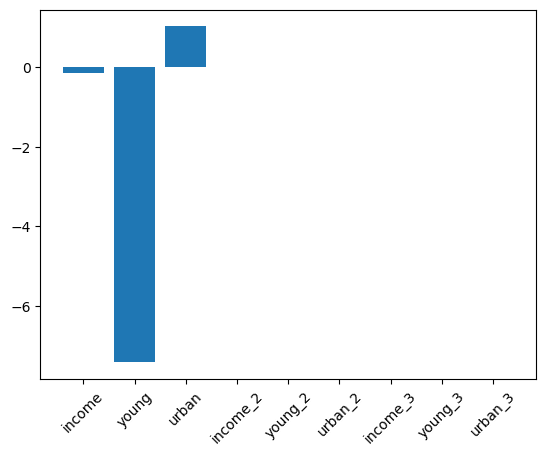

In [34]:
## Ridge Regression (badly done)
ridge = Ridge(alpha = 1).fit(X, y)
print('The R-squared for this regression is: ' + str(ridge.score(X, y)))
plt.bar(X.columns, ridge.coef_)
plt.xticks(rotation=45)
plt.show()

## Ridge Regression

- $\alpha = 0$ is the same as the least square regression.

- As $\alpha$ grows, the shrinkage penalty increases, and the ridge coefficients approach zero.

**Caveat 1**: The scale of the variable influences the results.

- In a OLS (standard least square regression), when you multiply $x_j$ by $c \neq 0$, you divide $\beta_j$ by $\dfrac{1}{c}$.

- Example: If you measure GDP in USD vs Millions of USD changes the ridge regression coefficient significantly.

**Suggestion**: Standardize the variables before running the regression

## Ridge Regression

### Standardization

- Let a variable $x_j$. Then, the standardized variable $z_j$ is obtained by:
    1. Subtracting the mean of the variable $x_j$ ($\overline{x}_j$) and then,
    2. Dividing the result by the standard deviation ($\sigma_{x_j}$) of the variable $x_j$.

$$ z_j \ = \ \dfrac{x_j - \overline{x}_j}{\sigma_{x_j}} $$

- The resulting variable $z_j$ has mean zero, variance one, and has no unit!

- Variations of one unit are called *deviations*: In a regression with a standardized variable, we say that $\beta_j$ would represent a variation on average $y$ when we increase $z_j$ by one standard-deviation.

- This is a great practice for prediction, but in general, be mindful about the unit of your data.

- **Again:** In a standard least square regression, when you multiply $x_j$ by $c \neq 0$, you divide $\beta_j$ by $\dfrac{1}{c}$.

In [15]:
## Standardizing the X variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# First observation:
print(list(X.iloc[0]))
print(list(X_scaled[0])) 

[2824.0, 350.7, 508.0, 7974976.0, 122990.48999999999, 258064.0, 22521332224.0, 43132764.842999995, 131096512.0]
[-0.7236935623908923, -0.3450642975121714, -1.044417328024432, -0.7523179270273195, -0.3599514179092925, -1.03909576213098, -0.7617030030625055, -0.37201867365836544, -0.9953964232882246]


The R-squared for this regression is: 0.7062378535723208


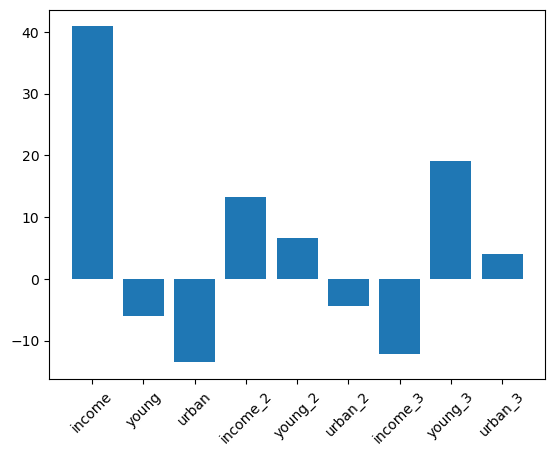

In [39]:
## Ridge Regression (greatly done)
ridge = Ridge(alpha = 1).fit(X_scaled, y)
print('The R-squared for this regression is: ' + str(ridge.score(X_scaled, y)))
plt.bar(X.columns, ridge.coef_)
plt.xticks(rotation=45)
plt.show()

## Ridge Regression

- **Caveat 2**: The ridge regression produces a different set of parameter for each $\alpha$.
    + $\widehat{\beta}_{\alpha}^{R}$

- Also note that the intercept ($\beta_0$) is not considered.
    + We do not want to shrink the mean of $y_i$ when $x_{ij} = 0$ for all $j$.
    + And if we standardize the variables, then the intercept will be $\widehat{\beta}_0 = \overline{y}$.

## Ridge Regression (book calls the reg parameter $\lambda$)

![img](../img/ridge1.png)

In [40]:
## Example by Kornel Kielczewski in the sklearn documentation, adapted by me.
ridge = Ridge()
coefs = list()
errors = list()
alphas = np.logspace(-6, 6, 200)

for a in alphas:
    ridge.set_params(alpha = a).fit(X_scaled, y)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_scaled) - y) ** 2))

coefs = pd.DataFrame(coefs, columns = X.columns, index = alphas)
print(errors[0:5])
coefs.head()

[496.7541409012298, 496.75872644478574, 496.76468170844765, 496.7723978903649, 496.782369367379]


,income,young,urban,income_2,young_2,urban_2,income_3,young_3,urban_3
0.000001,-67.074874,-1972.450244,208.787188,383.996347,3780.872647,-537.149445,-276.113692,-1790.787122,316.455354
0.000001,-67.109924,-1962.809279,208.486396,383.999187,3761.703740,-536.490651,-276.099839,-1781.235925,316.110943
0.000001,-67.149365,-1951.852113,208.144395,384.001574,3739.917880,-535.741598,-276.083645,-1770.380803,315.719336
0.000002,-67.193605,-1939.418308,207.756115,384.003182,3715.196082,-534.891181,-276.064677,-1758.062820,315.274720
0.000002,-67.243043,-1925.333610,207.316035,384.003560,3687.191895,-533.927303,-276.042418,-1744.109358,314.770766


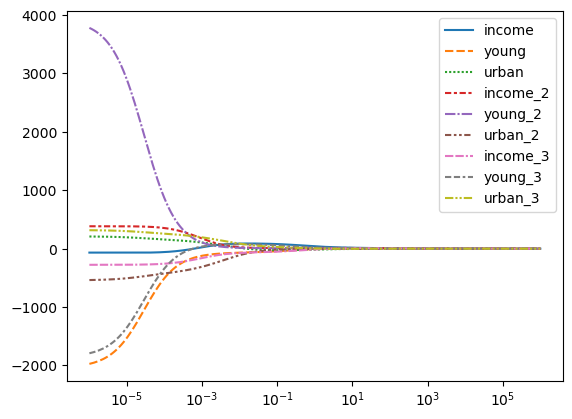

In [18]:
# Coefficients as a function of the regularization paramenter alpha
g = sns.lineplot(data = coefs)
g.set(xscale='log')
plt.show()

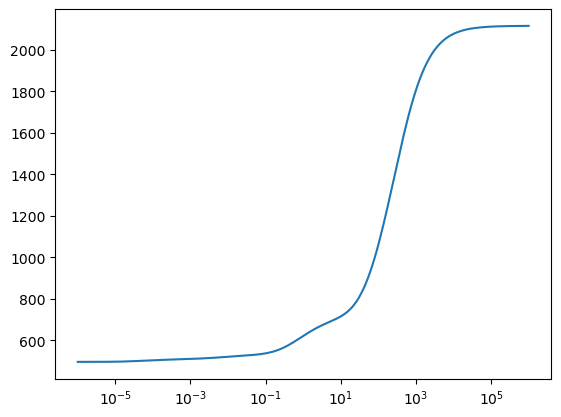

In [19]:
# Mean Squared Error as a function of the regularization paramenter alpha
g = sns.lineplot(x = alphas, y = errors)
g.set(xscale='log')
plt.show()

## Ridge Regression

- Advantage: the *non-obvious* advantage is that as $\alpha$ increses, the flexibility of the model decreases.

- This decreases variance (but increase bias).

- This may be "optimized": You may find the optimal bias-variance trade-off by manipulating $\alpha$.

## Ridge Regression

- Specially important when $p$ is close to $n$ (number of predictors is close to the number of cases).
    + This is called *high dimensional data*.

- If $p > n$, then ridge does very well. This case would have a very high variance.

- And it is *way* better than *best subset selection*: you fit just one model:
    + In practice, as many as the different $\alpha$s.
    + There are algorithms to solve efficiently for all $\alpha$s, which means that it may be more efficient than best, forward, and backward stepwise selection.

## Ridge Regression (the book calls the regularization parameter $\lambda$) 

![img](../img/ridge2.png)


# Cross-Validation

## Cross-Validation

- To select the tuning parameters you can use cross-validation.

- The idea is to search through a grid of tuning parameter candidates, selecting the one that does best in the cross-validation.

- It is indeed a very straight-forward idea, if you think about it.

## Cross-Validation (the book calls the regularization parameter $\lambda$) 

![img](../img/cvridge.png)

In [41]:
## Ridge with Cross-Validation
ridge = Ridge()
coefs = list()
errors = list()
CVerrors = list()
alphas = np.logspace(-6, 6, 200)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 12345)

for a in alphas:
    ridge.set_params(alpha = a).fit(X_train, y_train)
    CVerrors.append(np.mean((ridge.predict(X_test) - y_test) ** 2))
    errors.append(np.mean((ridge.predict(X_train) - y_train) ** 2))

print('The alpha that minimizes the ridge testing set MSE is: ' + str(alphas[CVerrors.index(min(CVerrors))]))
    
mses = pd.DataFrame({
    'trainMSE': errors,
    'testMSE': CVerrors}, index = alphas)

The alpha that minimizes the ridge testing set MSE is: 0.03827494478516307


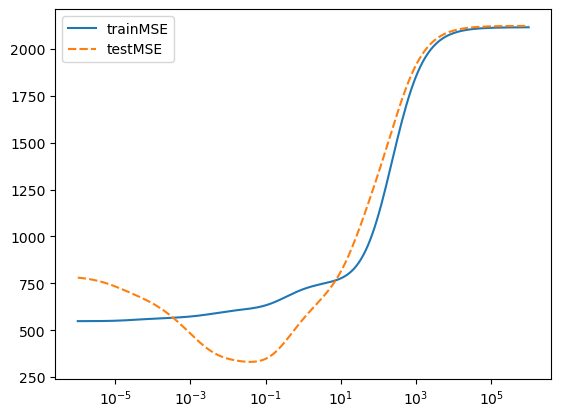

In [21]:
# Cross Validation Ridge MSE as a function of the regularization parameter alpha
g = sns.lineplot(data = mses)
g.set(xscale='log')
plt.show()

# Questions?

# See you next class
